In [8]:
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}


In [14]:
library(dplyr)
library(hipathia)

In [10]:
## ==============================
## PARAMETERS
## ==============================

# Input files
rna_path  <- "rna_data_filtered wtumor.csv"          # raw RNA matrix (csv or tsv)
meta_path <- "complet_cell_metadata_grouped.csv"   # cleaned metadata with 'cell_id' and 'group'

# Output files
rna_standardized_out <- "rna_standardized.csv"   # standardized Gene × Cells
expr_pseudobulk_out  <- "expr_pseudobulk_symbols.csv" # Gene × Samples after pseudobulk
design_out           <- "design.csv"             # SampleID × Group (Tumor/Normal)

# Options
pseudobulk_method <- "mean"   # "mean" for normalized data, "sum" if raw counts
min_overlap_prop  <- 0.9      # threshold for barcode overlap warning

#Pathaways
species <- "hsa"
pathways_list <- c()   # Beispiel: c("hsa03320", "hsa04014") 
                       # oder einfach leer lassen: c()



In [10]:
## ==============================
## RNA Reader + Standardizer
## ==============================

## ---- Helper functions
read_tab <- function(p) {
  if (grepl("\\.tsv$", p, ignore.case = TRUE)) {
    read.delim(p, stringsAsFactors = FALSE, check.names = FALSE)
  } else if (grepl("\\.csv$", p, ignore.case = TRUE)) {
    read.csv(p, stringsAsFactors = FALSE, check.names = FALSE)
  } else stop("Unknown format: expecting .csv or .tsv, got: ", p)
}

looks_barcode <- function(x) {
  grepl("[-_]", x) | grepl("-\\d+$", x)
}

looks_gene_symbol <- function(v) {
  v <- as.character(v)
  all(!grepl("-", v, fixed = TRUE)) &&
    mean(grepl("[A-Za-z]", v), na.rm = TRUE) > 0.6 &&
    mean(!grepl("^\\d+$", v), na.rm = TRUE) > 0.9
}

is_strict_index_col <- function(v) {
  v <- suppressWarnings(as.numeric(v))
  if (all(is.na(v))) return(FALSE)
  n <- length(v)
  sum(!is.na(v)) == n && identical(v, seq_len(n))
}

trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (j in seq_along(df)) if (is.character(df[[j]])) df[[j]] <- trimws(df[[j]])
  df
}

## ---- Read file
rna_raw <- read_tab(rna_path)
rna_raw <- trim_all(rna_raw)

empty_cols <- which(sapply(rna_raw, function(col) all(is.na(col) | col == "")))
if (length(empty_cols)) rna_raw <- rna_raw[ , -empty_cols, drop = FALSE]

stopifnot(ncol(rna_raw) >= 2)

## ---- Detect format
cn <- colnames(rna_raw)

drop_first <- FALSE
if (is_strict_index_col(rna_raw[[1]]) || toupper(cn[1]) %in% c("X","INDEX","ROW","IDS","ID")) {
  drop_first <- TRUE
}

rna1 <- if (drop_first) rna_raw[, -1, drop = FALSE] else rna_raw
cn1 <- colnames(rna1)

gene_col_idx <- NA_integer_
cand_idx <- seq_len(min(2, ncol(rna1)))
for (k in cand_idx) {
  samp <- head(rna1[[k]], 200)
  if (looks_gene_symbol(samp)) { gene_col_idx <- k; break }
}

transposed <- FALSE
if (is.na(gene_col_idx)) {
  prop_barcode_in_colnames <- mean(looks_barcode(cn1))
  prop_barcode_in_firstcol <- mean(looks_barcode(head(rna1[[1]], 200)))
  if (!is.na(prop_barcode_in_firstcol) && prop_barcode_in_firstcol > 0.6 &&
      !is.na(prop_barcode_in_colnames) && prop_barcode_in_colnames < 0.4) {
    transposed <- TRUE
  } else {
    gene_col_idx <- 1L
  }
}

## ---- Transpose if needed
if (transposed) {
  message("Detected transposed file (barcodes in rows). Transposing ...")
  barcodes <- as.character(rna1[[1]])
  mat <- as.data.frame(t(rna1[, -1, drop = FALSE]), stringsAsFactors = FALSE, check.names = FALSE)
  colnames(mat) <- barcodes
  mat <- cbind(Gene = rownames(mat), mat, row.names = NULL, check.names = FALSE)
  rna2 <- mat
} else {
  if (is.na(gene_col_idx)) gene_col_idx <- 1L
  colnames(rna1)[gene_col_idx] <- "Gene"
  rna2 <- rna1
}

## ---- Clean up
cn2 <- colnames(rna2)
if (!"Gene" %in% cn2) stop("Could not determine 'Gene' column. Please check file.")

barcode_cols <- setdiff(cn2, "Gene")

for (bc in barcode_cols) {
  if (is.character(rna2[[bc]])) {
    rna2[[bc]] <- gsub(",+$", "", rna2[[bc]])
  }
}
for (bc in barcode_cols) {
  rna2[[bc]] <- suppressWarnings(as.numeric(rna2[[bc]]))
}

rna2$Gene <- as.character(rna2$Gene)
rna2 <- rna2[!is.na(rna2$Gene) & rna2$Gene != "", , drop = FALSE]

if (any(duplicated(rna2$Gene))) {
  message("Duplicate gene names found -> aggregating by mean.")
  rna2 <- stats::aggregate(. ~ Gene, data = rna2, FUN = function(x) mean(as.numeric(x), na.rm = TRUE))
}

for (bc in barcode_cols) {
  nas <- is.na(rna2[[bc]])
  if (any(nas)) rna2[[bc]][nas] <- 0
}

## ---- Write standardized file
write.csv(rna2, rna_standardized_out, row.names = FALSE)
message("rna_standardized.csv written: column 'Gene' + ", length(barcode_cols), " barcode columns.")

## ---- Optional: check overlap with metadata
if (file.exists(meta_path)) {
  meta <- tryCatch(read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE), error = function(e) NULL)
  if (!is.null(meta) && "cell_id" %in% colnames(meta)) {
    meta_ids <- trimws(as.character(meta$cell_id))
    cols <- setdiff(colnames(rna2), "Gene")
    in_both <- intersect(meta_ids, cols)
    prop <- if (length(cols) == 0) 0 else length(in_both) / length(cols)
    cat("\n===== Barcode-Check (optional) =====\n")
    cat("Barcodes in RNA (columns): ", length(cols), "\n", sep = "")
    cat("Barcodes in Metadata:      ", length(meta_ids), "\n", sep = "")
    cat("Overlap:                   ", length(in_both), " (", sprintf("%.2f", 100*prop), "%)\n", sep = "")
    if (prop < min_overlap_prop) {
      warning("Less than 90% overlap between RNA barcodes and Metadata cell_id. Check naming/subsetting.")
    } else {
      message("Barcode overlap OK (>=90%).")
    }
  } else {
    message("Metadata file present, but no 'cell_id' column found – skipping barcode check.")
  }
}


rna_standardized.csv written: column 'Gene' + 1000 barcode columns.




===== Barcode-Check (optional) =====
Barcodes in RNA (columns): 1000
Barcodes in Metadata:      84526
Overlap:                   1000 (100.00%)


Barcode overlap OK (>=90%).



In [11]:
## ==============================
## Pseudobulk (Cells -> Samples) + Design
## Uses:
##   - rna_standardized_out (Gene × Cells)
##   - meta_path (metadata with 'cell_id', 'orig.ident', 'group')
## Produces:
##   - expr_pseudobulk_out  (Gene × Samples)
##   - design_out           (sample_id, group)
## ==============================

# ---- Read inputs
rna_std <- read.csv(rna_standardized_out, stringsAsFactors = FALSE, check.names = FALSE)
meta    <- read.csv(meta_path,             stringsAsFactors = FALSE, check.names = FALSE)

# ---- Basic checks
if (!"Gene" %in% colnames(rna_std)) stop("Standardized RNA must contain column 'Gene'.")
if (!"cell_id" %in% colnames(meta)) stop("Metadata must contain column 'cell_id'.")
if (!"orig.ident" %in% colnames(meta)) stop("Metadata must contain column 'orig.ident'.")
if (!"group" %in% colnames(meta)) stop("Metadata must contain column 'group' (Tumor/Normal).")

# ---- Align RNA barcodes (columns) with metadata cell_id
rna_barcodes <- setdiff(colnames(rna_std), "Gene")
meta_ids     <- trimws(as.character(meta$cell_id))
keep_cells   <- intersect(rna_barcodes, meta_ids)

if (length(keep_cells) == 0) {
  stop("No overlap between RNA barcodes and metadata cell_id.")
}

# Subset RNA to overlapping cells (keep Gene column)
rna_sub <- rna_std[, c("Gene", keep_cells), drop = FALSE]

# ---- Build mapping: cell_id -> orig.ident (sample) + group
meta_map <- meta[match(keep_cells, meta$cell_id), c("cell_id","orig.ident","group")]
colnames(meta_map) <- c("cell_id","sample_id","group")

# ---- Convert RNA to numeric matrix (cells only)
mat <- as.matrix(rna_sub[, -1, drop = FALSE])
mode(mat) <- "numeric"
rownames(mat) <- rna_sub$Gene

# ---- Aggregate per sample_id (orig.ident)
samples <- unique(meta_map$sample_id)

agg_one <- function(smpl) {
  cols <- which(meta_map$sample_id == smpl)
  if (length(cols) == 1L) {
    mat[, cols, drop = FALSE]
  } else {
    if (tolower(pseudobulk_method) == "sum") {
      matrix(rowSums(mat[, cols, drop = FALSE], na.rm = TRUE), ncol = 1,
             dimnames = list(rownames(mat), smpl))
    } else {
      matrix(rowMeans(mat[, cols, drop = FALSE], na.rm = TRUE), ncol = 1,
             dimnames = list(rownames(mat), smpl))
    }
  }
}

pb_list <- lapply(samples, agg_one)
pb_mat  <- do.call(cbind, pb_list)

# ---- Build pseudobulk dataframe
expr_pseudobulk <- data.frame(Gene = rownames(pb_mat), pb_mat, check.names = FALSE)

# ---- Collapse duplicated genes (mean)
if (any(duplicated(expr_pseudobulk$Gene))) {
  expr_pseudobulk <- aggregate(. ~ Gene, data = expr_pseudobulk, FUN = function(x) mean(as.numeric(x), na.rm = TRUE))
}

## ---- Build design: one row per sample_id, assign group by majority vote (Base R version)
design <- aggregate(group ~ sample_id, data = meta_map, FUN = function(x) {
  if (mean(x == "Tumor", na.rm = TRUE) >= 0.5) "Tumor" else "Normal"
})

# ---- Write outputs
write.csv(expr_pseudobulk, expr_pseudobulk_out, row.names = FALSE)
write.csv(design,           design_out,          row.names = FALSE)

# ---- Report
cat("\n===== PSEUDOBULK DONE =====\n")
cat("Samples (orig.ident): ", paste(colnames(expr_pseudobulk)[-1], collapse = ", "), "\n", sep = "")
cat("Genes (rows):         ", nrow(expr_pseudobulk), "\n", sep = "")
cat("Design rows:          ", nrow(design), "\n", sep = "")
cat("Files written:        ", expr_pseudobulk_out, ", ", design_out, "\n", sep = "")



===== PSEUDOBULK DONE =====
Samples (orig.ident): p786pos, p786neg, p811, p826, p846, p848, p4, p8pos, p8neg, p7, p9, p10, p11, p12, p13
Genes (rows):         31915
Design rows:          15
Files written:        expr_pseudobulk_symbols.csv, design.csv


In [12]:
## ==============================
## Step 1: Map Gene Symbols to Entrez IDs
## ==============================

# Install Bioconductor annotation package if missing
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

if (!requireNamespace("org.Hs.eg.db", quietly = TRUE))
    BiocManager::install("org.Hs.eg.db")

# Load library
library(org.Hs.eg.db)

# Read pseudobulk matrix (symbols)
expr_pb <- read.csv(expr_pseudobulk_out, stringsAsFactors = FALSE, check.names = FALSE)

# Check
if (!"Gene" %in% colnames(expr_pb)) stop("Expression file must contain column 'Gene'.")

# Map Gene Symbols -> Entrez IDs
gene_symbols <- expr_pb$Gene
entrez_ids <- mapIds(org.Hs.eg.db,
                     keys = gene_symbols,
                     column = "ENTREZID",
                     keytype = "SYMBOL",
                     multiVals = "first")

# Add Entrez IDs to dataframe
expr_pb$EntrezID <- entrez_ids

# Remove rows without mapping
expr_pb <- expr_pb[!is.na(expr_pb$EntrezID), ]

# If there are duplicates, collapse by mean
expr_pb <- aggregate(. ~ EntrezID, data = expr_pb[, c("EntrezID", colnames(expr_pb)[-1])], 
                     FUN = function(x) if(is.numeric(x)) mean(as.numeric(x), na.rm = TRUE) else x[1])

# Rename first column to "Gene" (now Entrez IDs)
colnames(expr_pb)[1] <- "Gene"

# Save Entrez-based pseudobulk file
write.csv(expr_pb, "expr_pseudobulk_entrez.csv", row.names = FALSE)

cat("\n===== MAPPING DONE =====\n")
cat("Input genes (symbols): ", length(gene_symbols), "\n", sep = "")
cat("Mapped to Entrez IDs : ", nrow(expr_pb), "\n", sep = "")
cat("File written: expr_pseudobulk_entrez.csv\n")




Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for pa


===== MAPPING DONE =====
Input genes (symbols): 31915
Mapped to Entrez IDs : 22374
File written: expr_pseudobulk_entrez.csv


In [19]:
library(hipathia)

trans_data <- as.matrix(read.csv("expr_pseudobulk_entrez.csv",
                                 row.names = 1, check.names = FALSE))

# exakt der Vignetten-Schritt:
exp_data <- normalize_data(trans_data, by_quantiles = FALSE)

write.csv(data.frame(Gene=rownames(exp_data), exp_data, check.names=FALSE),
          "Vinette_Like_RNA-Data.csv", row.names=FALSE)


Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.



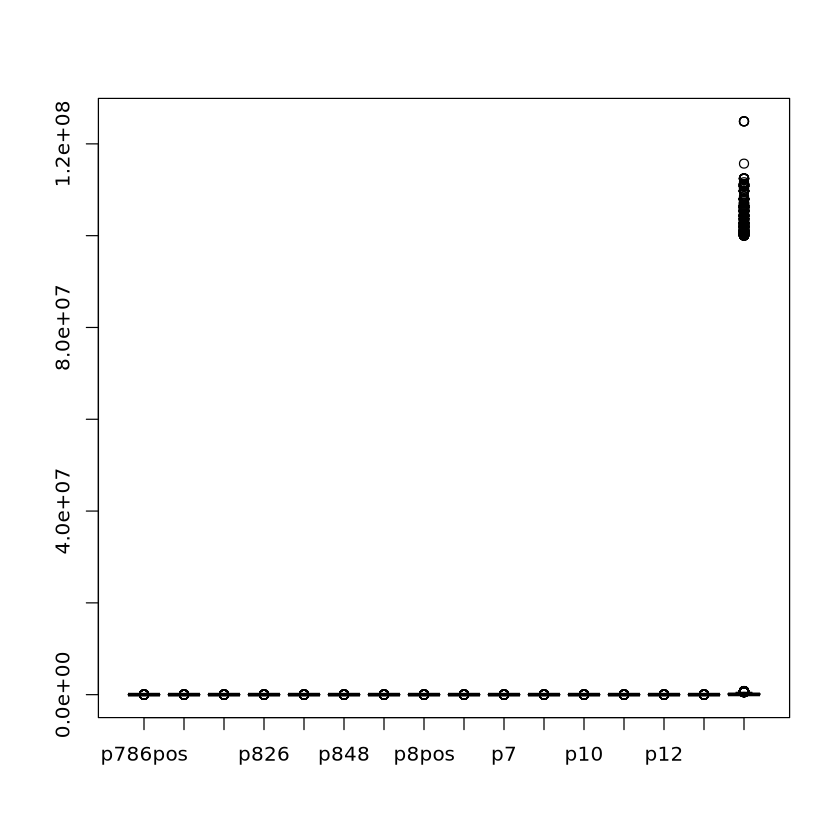

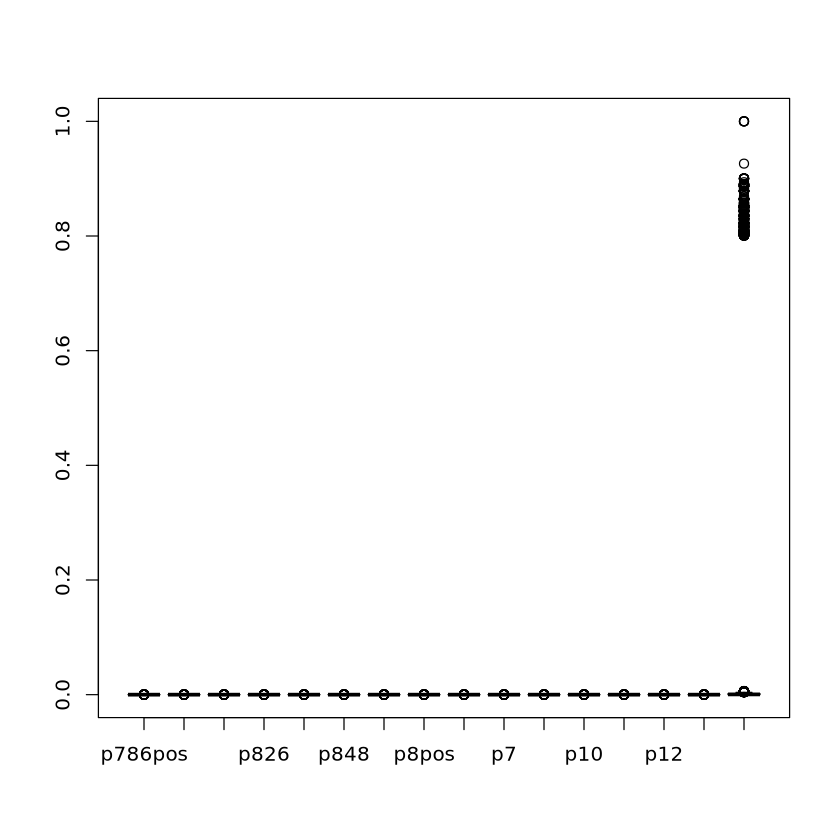

In [6]:
# vor Scaling
boxplot(trans_data)

# Limit threads (verhindert pthread-Fehler auf Clustern)
Sys.setenv(OMP_NUM_THREADS="1", MKL_NUM_THREADS="1",
           OPENBLAS_NUM_THREADS="1", VECLIB_MAXIMUM_THREADS="1")

# Versuche Quantile-Norm, sonst nimm Truncation wie in der Vignette
exp_data <- tryCatch(
  normalize_data(trans_data, by_quantiles = TRUE),
  error = function(e) {
    message("Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.")
    normalize_data(trans_data, truncation_percentil = 0.95)
  }
)

boxplot(exp_data)


In [15]:
if (length(pathways_list) == 0) {
    message("No pathway list provided -> loading ALL pathways for ", species)
    pathways <- load_pathways(species = species)
} else {
    message("Loading subset of pathways: ", paste(pathways_list, collapse = ", "))
    pathways <- load_pathways(species = species, pathways_list = pathways_list)
}

# ---- Check
length(pathways)   # Anzahl geladener Pathways
names(pathways)[1:5]  # Erste 5 Pathways anzeigen
get_pathways_list(pathways)[1:10]

No pathway list provided -> loading ALL pathways for hsa

Loaded 146 pathways



[1] 7

[1] "species"     "all.genes"   "path.norm"   "eff.norm"    "pathigraphs"

[1] "hsa03320" "hsa03460" "hsa04010" "hsa04012" "hsa04014" "hsa04015"
 [7] "hsa04020" "hsa04022" "hsa04024" "hsa04062"

In [20]:
results <- hipathia(exp_data, pathways, decompose = FALSE, verbose=FALSE)
## Added missing genes: 165 (4.93%)

Added missing genes: 55 (0.25%)



In [21]:
results

A MultiAssayExperiment object of 2 listed
 experiments with user-defined names and respective classes.
 Containing an ExperimentList class object of length 2:
 [1] nodes: SummarizedExperiment with 6826 rows and 16 columns
 [2] paths: SummarizedExperiment with 1876 rows and 16 columns
Functionality:
 experiments() - obtain the ExperimentList instance
 colData() - the primary/phenotype DataFrame
 sampleMap() - the sample coordination DataFrame
 `$`, `[`, `[[` - extract colData columns, subset, or experiment
 *Format() - convert into a long or wide DataFrame
 assays() - convert ExperimentList to a SimpleList of matrices
 exportClass() - save data to flat files

In [4]:

path_vals <- get_paths_data(results)
hhead(path_vals, 4)

ERROR: Error in get_paths_data(results): could not find function "get_paths_data"


In [25]:
uniprot_vals <- quantify_terms(results, pathways, dbannot = "uniprot")

go_vals <- quantify_terms(results, pathways, dbannot = "GO")


Quantified Uniprot terms: 43

Quantified GO terms: 231



In [31]:
meta <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)

# Sample-Level-Design erzeugen
tab <- aggregate(list(tumor_frac = as.numeric(meta$group == "Tumor")),
                 by = list(orig.ident = meta$orig.ident),
                 FUN = function(x) mean(x, na.rm = TRUE))
design <- data.frame(orig.ident = tab$orig.ident,
                     group = ifelse(tab$tumor_frac >= 0.5, "Tumor", "Normal"),
                     stringsAsFactors = FALSE)

# optional speichern, damit du es immer wieder verwenden kannst
write.csv(design, "design.csv", row.names = FALSE)

                 meta <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)

# Sample-Level-Design erzeugen
tab <- aggregate(list(tumor_frac = as.numeric(meta$group == "Tumor")),
                 by = list(orig.ident = meta$orig.ident),
                 FUN = function(x) mean(x, na.rm = TRUE))
design <- data.frame(orig.ident = tab$orig.ident,
                     group = ifelse(tab$tumor_frac >= 0.5, "Tumor", "Normal"),
                     stringsAsFactors = FALSE)

# optional speichern, damit du es immer wieder verwenden kannst
write.csv(design, "design.csv", row.names = FALSE)


In [3]:
# & Pathway/Funktion activation analysis
# falls gespeichert:
# 1) Nicht gematchte Spalten (z. B. "EntrezID.1") entfernen
path_vals <- path_vals[, colnames(path_vals) %in% design$orig.ident, drop = FALSE]

# 2) Gruppen passend zu den (bereinigten) Spalten holen
sample_group <- design[colnames(path_vals), "group"]

# 3) Test wie in der Vignette
comp <- do_wilcoxon(path_vals, sample_group, g1 = "Tumor", g2 = "Normal")
head(comp)




ERROR: Error: object 'path_vals' not found


In [35]:
anyNA(sample_group)
which(is.na(sample_group))
colnames(path_vals)[is.na(sample_group)]


[1] FALSE

integer(0)

character(0)

In [12]:
head(colnames(path_vals))
head(design$orig.ident)


[1] "TCGA.BH.A1FM.11B.23R.A13Q.07" "TCGA.E2.A1LB.11A.22R.A144.07"
[3] "TCGA.BH.A208.11A.51R.A157.07" "TCGA.BH.A18K.11A.13R.A12D.07"
[5] "TCGA.E9.A1RC.11A.33R.A157.07" "TCGA.E9.A1NG.11A.52R.A14M.07"

[1] "p786pos" "p786pos" "p786pos" "p786pos" "p786pos" "p786pos"

In [36]:
# 1) Gruppengrößen prüfen
table(sample_group)  # brauchst mind. ~3 je Gruppe

# 2) Konstante Subpfade rauswerfen (sd == 0)
keep <- apply(path_vals, 1, sd, na.rm = TRUE) > 0
sum(!keep)           # wie viele rausfliegen
path_vals2 <- path_vals[keep, , drop = FALSE]

# 3) Test erneut
comp <- do_wilcoxon(path_vals2, sample_group, g1 = "Tumor", g2 = "Normal")
head(comp[order(comp$FDRp.value), ], 10)


sample_group
Normal  Tumor 
    11      4 

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.matrix': no method for coercing this S4 class to a vector


In [2]:
table(sample_group)
stopifnot(min(table(sample_group)) >= 3)  # bricht ab, falls zu klein



ERROR: Error: object 'sample_group' not found


In [17]:
missing_genes <- setdiff(unique(pathways$all.genes), rownames(exp_data))
length(missing_genes) / length(unique(pathways$all.genes)) * 100


[1] 4.926844